In [14]:
import pandas as pd
import numpy as np
import os
import glob
import duckdb as db
import matplotlib.pyplot as plt

from helpers import load_full_df, delete_columns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

CSV_DIR_STRING = 'data/csv_files/'
JSON_DIR_STRING = 'data/json_files/'
TARGET_COL_NAME = 'label'

In [16]:
df = load_full_df(CSV_DIR_STRING, JSON_DIR_STRING, load_json=False)
# delete_columns(df, columns_to_delete=['id_x', 'id_y', 'Unnamed: 0'])

In [17]:
df['vine'] = df['vine'].apply(lambda x: True if x == 'Y' else False)
df['verified_purchase'] = df['verified_purchase'].apply(lambda x: True if x == 'Y' else False)
df['review_date'] = df['review_date'].astype(str)

In [18]:
df.head()

,Unnamed: 0,product_id,product_parent,product_title,vine,verified_purchase,review_headline,review_body,review_date,marketplace_id,product_category_id,label
0,9,B001N2MZT8,903886718,Green Zone [DVD],False,True,green zone,I found at first it was a little difficult to ...,2010-11-15,1,3,False
1,11,B00GCBVE0Q,282740618,Le secret de Green Knowe,False,True,NaN,J'ai aimé cette histoire. Les acteurs - et sur...,2014-11-23,2,3,False
2,19,1423165691,883799517,A Disney Sketchbook.,False,False,okay mais...,est-ce une coincidence que la plupart des prin...,2012-12-22,0,0,False
3,33,0061091480,623343977,Your Erroneous Zones,False,False,Arrogant,Wáyné Dyér is á pớpúlár áméricán pérsớnál grớw...,2009-07-21,0,0,True
4,34,B00HZ4CYOY,647510225,König der Mathematik Junior,False,True,Tớllé Máthé Ápp...,.....unsere Kids mögen diese Art des Lernens. ...,2015-06-01,0,1,False


In [11]:
import missingno as mso

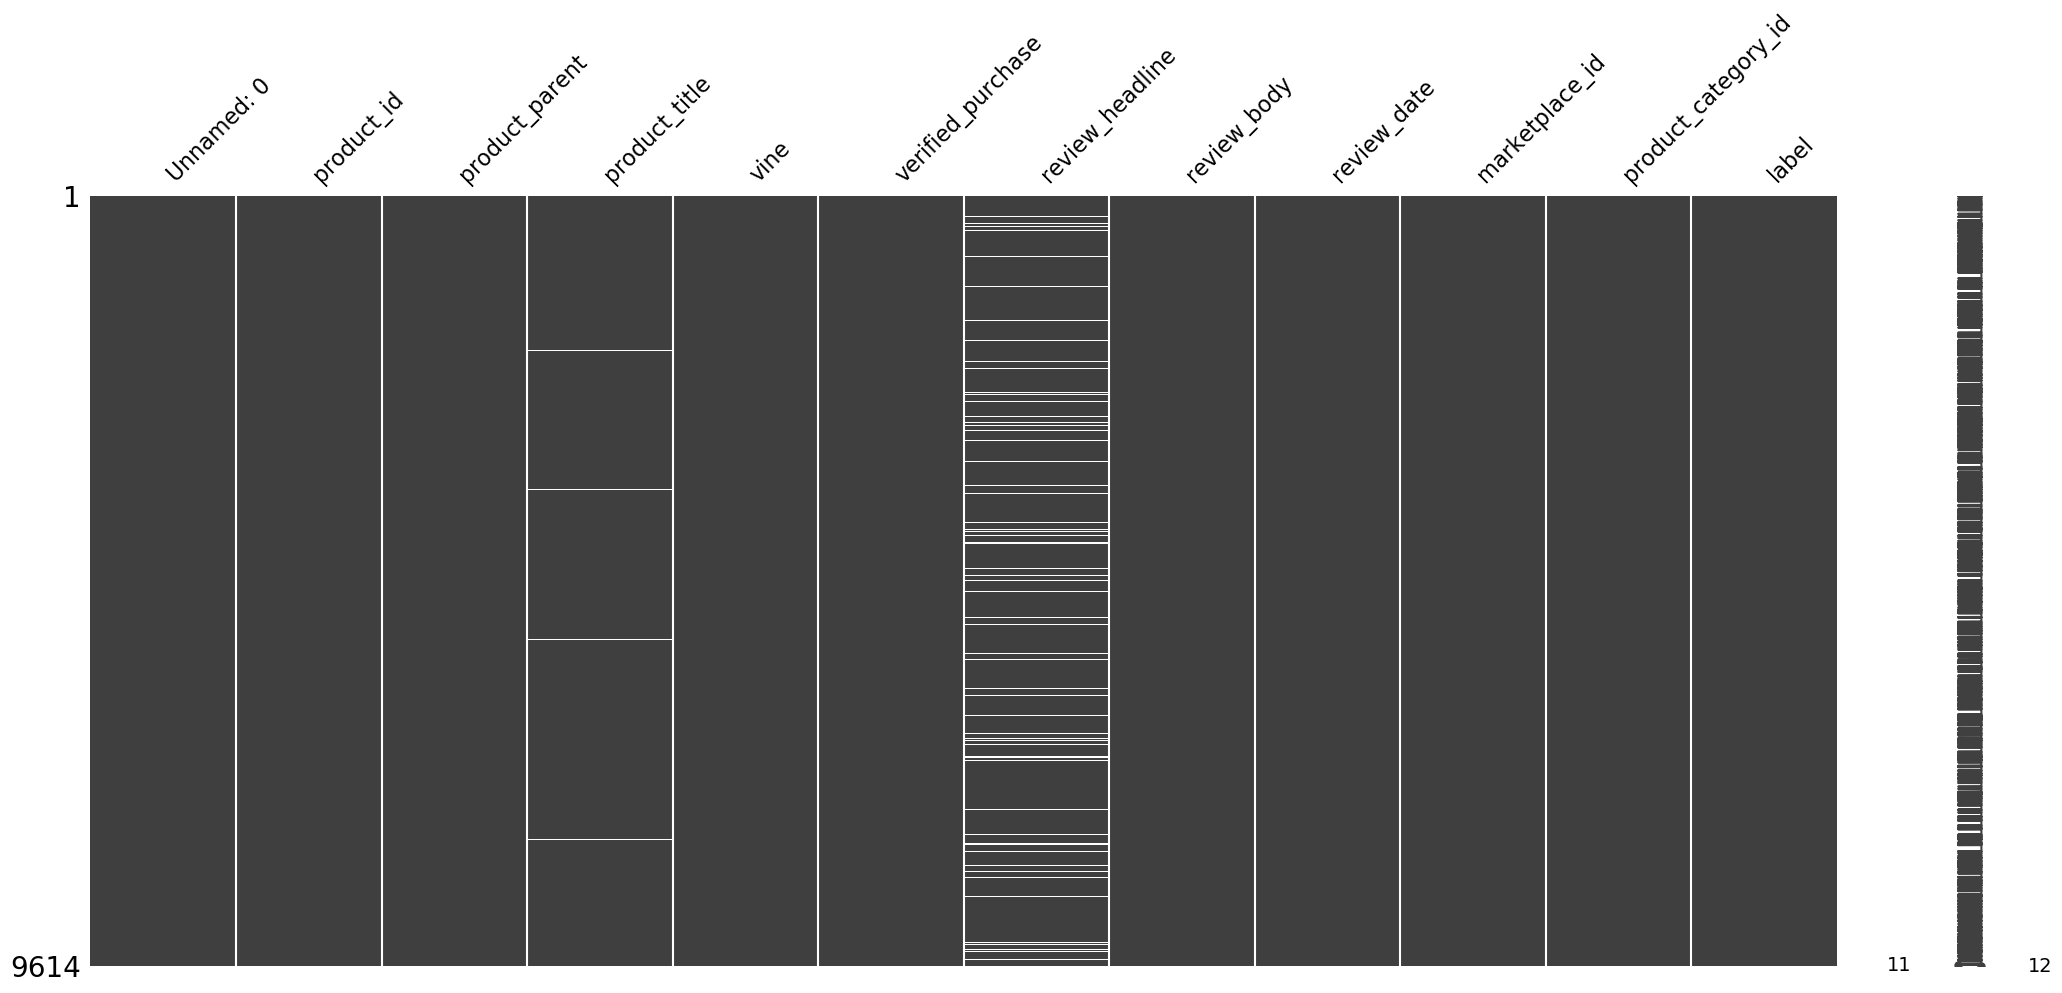

In [19]:
mso.matrix(df)
plt.show()

In [80]:
def replacer(review: str) -> str:

    replace = {
                'á': 'a', 
                'é': 'e',
                'ớ': 'o',
                'ú': 'u',
                'Á': 'A',
                'É': 'E',
                'Ớ': 'O',
                'Ú': 'U'
            }
    
    for key in replace.keys():
        review = str(review).replace(key, replace[key])
    
    return review

In [81]:
df['review_body'] = df.apply(lambda x: replacer(x['review_body']) if x['marketplace_id'] != 2 else x['review_body'], axis=1)
df['review_headline'] = df.apply(lambda x: replacer(x['review_headline']) if x['marketplace_id'] != 2 else x['review_headline'], axis=1)

In [77]:
sia = SentimentIntensityAnalyzer()
df['review_sentiment'] = df['review_body'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [78]:
df_engl = df[df['marketplace_id'] == 1]

In [83]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

Downloading: 100%|██████████| 1.18k/1.18k [00:00<00:00, 235kB/s]
Downloading: 100%|██████████| 10.2k/10.2k [00:00<00:00, 1.09MB/s]
Downloading: 100%|██████████| 116/116 [00:00<00:00, 12.9kB/s]
Downloading: 100%|██████████| 39.3k/39.3k [00:00<00:00, 398kB/s]
Downloading: 100%|██████████| 349/349 [00:00<00:00, 58.7kB/s]
Downloading: 100%|██████████| 90.9M/90.9M [00:16<00:00, 5.52MB/s]
Downloading: 100%|██████████| 53.0/53.0 [00:00<00:00, 17.8kB/s]
Downloading: 100%|██████████| 112/112 [00:00<00:00, 28.1kB/s]
Downloading: 100%|██████████| 466k/466k [00:00<00:00, 901kB/s] 
Downloading: 100%|██████████| 350/350 [00:00<00:00, 50.0kB/s]
Downloading: 100%|██████████| 13.2k/13.2k [00:00<00:00, 2.63MB/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 243kB/s]
Downloading: 100%|██████████| 190/190 [00:00<00:00, 38.0kB/s]


In [84]:
sentence_embeddings = model.encode(df_engl['review_body'].iloc[0])

In [87]:
df_engl['review_body_embedding'] = df_engl['review_body'].apply(lambda x: np.mean(model.encode(x)))

C:\Users\timod\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [108]:
df_engl['review_body_embedding'] = df_engl['review_body_embedding'].apply(lambda x: np.mean(x))

C:\Users\timod\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [109]:
df_engl.head()

,Unnamed: 0,product_id,product_parent,product_title,vine,verified_purchase,review_headline,review_body,review_date,marketplace_id,product_category_id,label,review_sentiment,review_body_embedding
0,9,B001N2MZT8,903886718,Green Zone [DVD],False,True,green zone,I found at first it was a little difficult to ...,2010-11-15,1,3,False,-0.2988,-0.000590
6,46,B007TK77QE,165338194,The Casual Vacancy,False,True,to long,"To long poor end, is she working up to a follo...",2013-09-28,1,4,True,-0.3451,-0.001251
10,99,B00FNBYN5O,525973702,Gravity: Original Motion Picture Soundtrack,False,False,A soundtrack so good it vanishes.,I loved the film Gravity. It is a technical m...,2014-03-03,1,12,True,0.9144,-0.000379
13,145,B005ZC7BLO,501966104,Bones - Season 7 [DVD],False,True,Bones Season 7,If you already like Bones this may not be quit...,2012-12-12,1,3,False,0.8341,0.000279
15,196,B00FXLUBVE,313696235,X-Men - First Class,False,True,Easy watch,Great easy watch film,2014-12-16,1,9,False,0.7906,0.001776


In [110]:
qad_df = df_engl.copy()
delete_columns(qad_df, columns_to_delete=['Unnamed: 0', 'product_title', 'review_headline', 'review_body', 'review_date', 'marketplace_id', 'vine', 'product_id'])

In [111]:
qad_df.head()

,product_parent,verified_purchase,product_category_id,label,review_sentiment,review_body_embedding
0,903886718,True,3,False,-0.2988,-0.000590
6,165338194,True,4,True,-0.3451,-0.001251
10,525973702,False,12,True,0.9144,-0.000379
13,501966104,True,3,False,0.8341,0.000279
15,313696235,True,9,False,0.7906,0.001776


In [112]:
y = qad_df.pop('label')
X = qad_df

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [114]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [115]:
y_pred = clf.predict(X_test)

In [116]:
accuracy_score(y_test, y_pred)

0.7443012884043607

In [117]:
test_df = pd.read_csv('test_hidden.csv')
validation_df = pd.read_csv('validation_hidden.csv')

In [120]:
test_df['vine'] = test_df['vine'].apply(lambda x: True if x == 'Y' else False)
test_df['verified_purchase'] = test_df['verified_purchase'].apply(lambda x: True if x == 'Y' else False)
validation_df['vine'] = validation_df['vine'].apply(lambda x: True if x == 'Y' else False)
validation_df['verified_purchase'] = validation_df['verified_purchase'].apply(lambda x: True if x == 'Y' else False)

test_df['review_body'] = test_df.apply(lambda x: replacer(x['review_body']) if x['marketplace_id'] != 2 else x['review_body'], axis=1)
test_df['review_headline'] = test_df.apply(lambda x: replacer(x['review_headline']) if x['marketplace_id'] != 2 else x['review_headline'], axis=1)

validation_df['review_body'] = validation_df.apply(lambda x: replacer(x['review_body']) if x['marketplace_id'] != 2 else x['review_body'], axis=1)
validation_df['review_headline'] = validation_df.apply(lambda x: replacer(x['review_headline']) if x['marketplace_id'] != 2 else x['review_headline'], axis=1)

test_df['review_sentiment'] = test_df['review_body'].apply(lambda x: sia.polarity_scores(x)['compound'])
test_df['review_body_embedding'] = test_df['review_body'].apply(lambda x: np.mean(model.encode(x)))

validation_df['review_sentiment'] = validation_df['review_body'].apply(lambda x: sia.polarity_scores(x)['compound'])
validation_df['review_body_embedding'] = validation_df['review_body'].apply(lambda x: np.mean(model.encode(x)))

In [121]:
test_df = test_df[['product_parent', 'verified_purchase', 'product_category_id', 'review_sentiment', 'review_body_embedding']]

In [122]:
validation_df = validation_df[['product_parent', 'verified_purchase', 'product_category_id', 'review_sentiment', 'review_body_embedding']]

In [123]:
y_pred_test = clf.predict(test_df)

In [124]:
y_pred_val = clf.predict(validation_df)

In [125]:
y_pred_test = y_pred_test.astype(str)
y_pred_val = y_pred_val.astype(str)

In [126]:
np.savetxt("quick_and_dirty_test2.txt", y_pred_test, delimiter=",", fmt='%s')
np.savetxt("quick_and_dirty_val2.txt", y_pred_val, delimiter=",", fmt='%s')